<a href="https://colab.research.google.com/github/NavyaShetty-97/NavyaShetty-97.github.io/blob/master/FinalProject_ImageClassifier(SignLanguage).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
! pip install kaggle

In [35]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download datamunge/sign-language-mnist

100% 62.6M/62.6M [00:00<00:00, 171MB/s]
100% 62.6M/62.6M [00:00<00:00, 148MB/s]


In [ ]:
!unzip /content/sign-language-mnist.zip

Archive:  /content/sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [ ]:
#Import the library 
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

import csv
import string

import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.applications.inception_v3 import InceptionV3

from keras.callbacks import ReduceLROnPlateau

In [ ]:
!unzip /content/Dataset.zip

unzip:  cannot find or open /content/Dataset.zip, /content/Dataset.zip.zip or /content/Dataset.zip.ZIP.


In [ ]:
#Directory of Training dataset and Validation dataset
TRAINING_DATA = '../content/sign_mnist_train/sign_mnist_train.csv'
VALIDATION_DATA = '../content/sign_mnist_test/sign_mnist_test.csv'

In [ ]:
# loading the training file which is in csv format and printing the lines

with open(TRAINING_DATA) as training_data:
    line = training_data.readline()
    print(f"First line (header) looks like this:\n{line}")
    line = training_data.readline()
    print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

In [ ]:
# printing the data from training data
pd.read_csv(TRAINING_DATA).head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
#To find Corrupted files 
#isna() detect the presence of NULL or NA values
print("Corrupted labels and pixels in train dataset: ", pd.read_csv(TRAINING_DATA).isna().sum().sum(), '\n'
        "Corrupted labels and pixels in validation dataset: ", pd.read_csv(VALIDATION_DATA).isna().sum().sum())

Corrupted labels and pixels in train dataset:  0 
Corrupted labels and pixels in validation dataset:  0


In [ ]:
#Parsing the dataset from input
def parse_data_from_input(filename):
  with open(filename) as file:

    # csv.reader can be iterated and in each iteration it returns one line
    csv_Reader = csv.reader(file, delimiter = ',')
    # header is skipped here
    next(csv_Reader)

    init_labels_array = []
    init_images_array = []
    for row in csv_Reader:
      labels = np.array(row[0]).astype('float64')
      images = np.array(row[1:]).reshape(28, 28).astype('float64')

      init_labels_array.append(labels)
      init_images_array.append(images)
    
    labels = np.array(init_labels_array)
    images = np.array(init_images_array)
    
    return images, labels

In [ ]:
training_Images, training_Labels = parse_data_from_input(TRAINING_DATA)
validation_Images, validation_Labels = parse_data_from_input(VALIDATION_DATA)

print(f"Shape of Training images: {training_Images.shape}")
print(f"Shape of Training labels: {training_Labels.shape}")
print(f"Shape of Validation images: {validation_Images.shape}")
print(f"Shape of Validation labels: {validation_Labels.shape}")

Shape of Training images: (27455, 28, 28)
Shape of Training labels: (27455,)
Shape of Validation images: (7172, 28, 28)
Shape of Validation labels: (7172,)


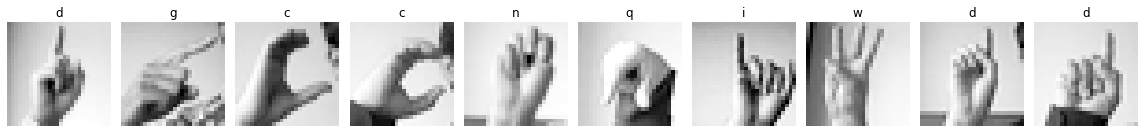

In [ ]:
# Plot a sample of 10 images from the training set
def plot_categories(training_Images, training_Labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_Images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_Labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_Images, training_Labels)

In [ ]:
train_df = pd.read_csv('../content/sign_mnist_train/sign_mnist_train.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
train_df.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [ ]:
train_df.label.value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [ ]:
labels = train_df["label"].value_counts().sort_index(ascending=True)

In [ ]:
# Plot the labels and their corresponding images
fig=px.bar(x=labels.index , y=labels.values,title="Labels and thier images",
       labels={"x":"Label","y":"Number of Images"},
       text=labels.values,
       color_discrete_sequence=["#ccc"],
           
      )
fig.update_layout(title_x=.5,title_font_color="#fff",title_font_size=20,paper_bgcolor="#334e5c",font_color="#fff",
                 plot_bgcolor="#0C2D48",
                   xaxis = dict(
                    tickmode = 'linear',
                    ticktext= labels.index
                     )
                 )
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# Reducing learning rate
learningRateReduction = ReduceLROnPlateau(monitor='loss', patience = 1, verbose=1,factor=0.75, min_lr=0.00000000001)

In [ ]:
def train_vald_generators(training_Images, training_Labels, validation_Images, validation_Labels):
    
  # Addition of another dimension to the data for channel
  # In this case, 1 channel since we are working with grayscale images
  # For example, if array is (27455, 28, 28)
  # We need to make it (27455, 28, 28, 1)
  training_images = np.expand_dims(training_Images, axis=3)
  validation_images = np.expand_dims(validation_Images, axis=3)

  # Instantiate the ImageDataGenerator class and also we need to normalize pixel values and set arguments to augment the images (if desired)
  # To avoid model from overfitting, we will augment the images
  train_datagenerator = ImageDataGenerator(rescale=1/255,
                                     rotation_range=45,
                                     height_shift_range=0.2,
                                     width_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.4,
                                     horizontal_flip=True)
  train_generator = train_datagenerator.flow(x=training_images,
                                       y=training_Labels,
                                       batch_size=32) 

  validation_datagenerator = ImageDataGenerator(rescale=1/255)
  validation_generator = validation_datagenerator.flow(x=validation_images,
                                                 y=validation_Labels,
                                                 batch_size=32) 

  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_vald_generators(training_Images, training_Labels, validation_Images, validation_Labels)

print(f"Shape of training generator images: {train_generator.x.shape}")
print(f"Shape of training generator labels: {train_generator.y.shape}")
print(f"Shape of validation generator have shape: {validation_generator.x.shape}")
print(f"Shape of validation generator have shape: {validation_generator.y.shape}")

Shape of training generator images: (27455, 28, 28, 1)
Shape of training generator labels: (27455,)
Shape of validation generator have shape: (7172, 28, 28, 1)
Shape of validation generator have shape: (7172,)


In [ ]:
#Building the CNN
def create_model():
    
    model = tf.keras.models.Sequential([
                                        
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')])

    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
  
    return model
    model.summary()

In [ ]:
# Saving our model
model = create_model()

In [ ]:
# Train our model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,  
                    callbacks = [learningRateReduction])

Epoch 1/20
858/858 [==============================] - 22s 15ms/step - loss: 2.3943 - accuracy: 0.2672 - val_loss: 1.6252 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 2/20
858/858 [==============================] - 13s 15ms/step - loss: 1.6182 - accuracy: 0.4821 - val_loss: 1.7121 - val_accuracy: 0.4948 - lr: 0.0010
Epoch 3/20
858/858 [==============================] - 13s 15ms/step - loss: 1.2758 - accuracy: 0.5859 - val_loss: 0.9765 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 4/20
858/858 [==============================] - 15s 17ms/step - loss: 1.0768 - accuracy: 0.6487 - val_loss: 0.7772 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 5/20
858/858 [==============================] - 13s 15ms/step - loss: 0.9556 - accuracy: 0.6864 - val_loss: 0.6471 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 6/20
858/858 [==============================] - 13s 16ms/step - loss: 0.8680 - accuracy: 0.7112 - val_loss: 0.5789 - val_accuracy: 0.7828 - lr: 0.0010
Epoch 7/20
858/858 [==============================] - 13s 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



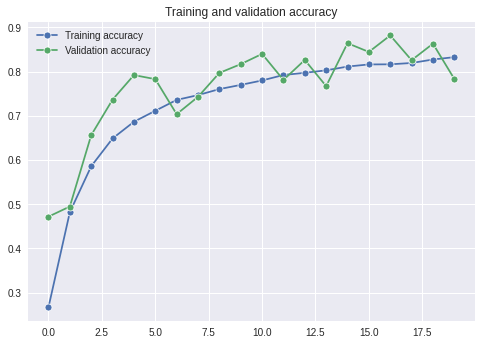

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



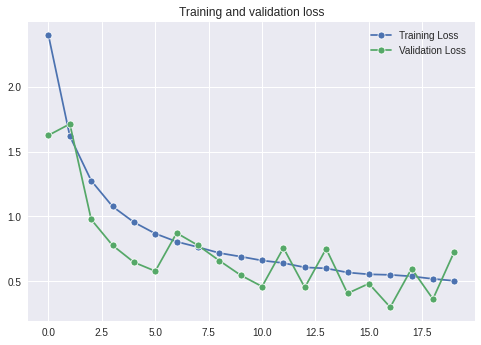

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
plt.style.use("seaborn")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.title('Training and validation accuracy')
sns.lineplot(epochs, acc, label="Training accuracy", marker="o")
sns.lineplot(epochs, val_acc, label="Validation accuracy", marker="o")
plt.show()

plt.figure()
plt.title("Training and validation loss")
sns.lineplot(epochs, loss, label="Training Loss", marker="o")
sns.lineplot(epochs, val_loss, label="Validation Loss", marker="o")
plt.show()


In [ ]:
#Model2
def create_model2():  
    
  model2 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                                     tf.keras.layers.MaxPooling2D(2,2),
                                     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(2,2),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(1024, activation='relu'),
                                     tf.keras.layers.Dense(26, activation='softmax')
                                     ])
  

  model2.compile(optimizer = 'rmsprop',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model2

In [ ]:
model2 = create_model2()

# Train our model
history1 = model2.fit(train_generator,
                    epochs=25,
                    validation_data=validation_generator,  
                    callbacks = [learningRateReduction])


Epoch 1/25
858/858 [==============================] - 14s 15ms/step - loss: 2.6684 - accuracy: 0.1883 - val_loss: 1.7504 - val_accuracy: 0.4039 - lr: 0.0010
Epoch 2/25
858/858 [==============================] - 13s 16ms/step - loss: 1.9027 - accuracy: 0.3992 - val_loss: 1.1153 - val_accuracy: 0.6014 - lr: 0.0010
Epoch 3/25
858/858 [==============================] - 13s 15ms/step - loss: 1.4472 - accuracy: 0.5328 - val_loss: 0.6685 - val_accuracy: 0.7914 - lr: 0.0010
Epoch 4/25
858/858 [==============================] - 13s 16ms/step - loss: 1.1835 - accuracy: 0.6092 - val_loss: 0.4664 - val_accuracy: 0.8332 - lr: 0.0010
Epoch 5/25
858/858 [==============================] - 12s 14ms/step - loss: 1.0223 - accuracy: 0.6678 - val_loss: 0.6067 - val_accuracy: 0.7758 - lr: 0.0010
Epoch 6/25
858/858 [==============================] - 12s 14ms/step - loss: 0.9100 - accuracy: 0.6991 - val_loss: 0.3493 - val_accuracy: 0.8839 - lr: 0.0010
Epoch 7/25
858/858 [==============================] - 12s 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



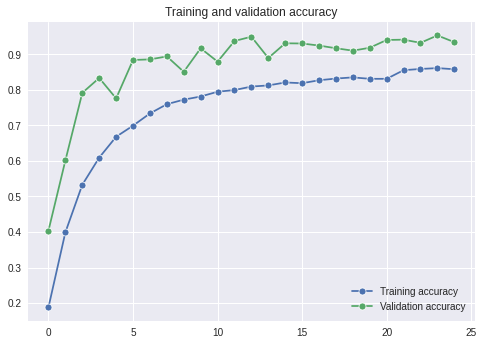

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



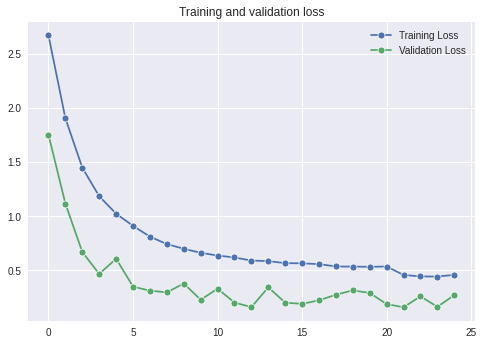

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
plt.style.use("seaborn")

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.title('Training and validation accuracy')
sns.lineplot(epochs, acc, label="Training accuracy", marker="o")
sns.lineplot(epochs, val_acc, label="Validation accuracy", marker="o")
plt.show()

plt.figure()
plt.title("Training and validation loss")
sns.lineplot(epochs, loss, label="Training Loss", marker="o")
sns.lineplot(epochs, val_loss, label="Validation Loss", marker="o")
plt.show()

In [ ]:
#Model3
def create_model3():  
    
  model3 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                                     tf.keras.layers.MaxPooling2D(2,2),
                                     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(2,2),
                                     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(2,2),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(4096, activation='relu'),
                                     tf.keras.layers.Dense(26, activation='softmax')
                                     ])
  

  model3.compile(optimizer = 'rmsprop',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model3

In [ ]:
model3 = create_model3()

# Train our model
history3 = model3.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,  
                    callbacks = [learningRateReduction])

Epoch 1/50
858/858 [==============================] - 13s 14ms/step - loss: 2.7906 - accuracy: 0.1456 - val_loss: 1.9820 - val_accuracy: 0.3101 - lr: 0.0010
Epoch 2/50
858/858 [==============================] - 12s 14ms/step - loss: 2.0786 - accuracy: 0.3366 - val_loss: 1.3795 - val_accuracy: 0.4941 - lr: 0.0010
Epoch 3/50
858/858 [==============================] - 12s 14ms/step - loss: 1.6402 - accuracy: 0.4641 - val_loss: 1.0325 - val_accuracy: 0.6555 - lr: 0.0010
Epoch 4/50
858/858 [==============================] - 12s 14ms/step - loss: 1.3846 - accuracy: 0.5426 - val_loss: 0.7389 - val_accuracy: 0.7305 - lr: 0.0010
Epoch 5/50
858/858 [==============================] - 12s 14ms/step - loss: 1.2259 - accuracy: 0.5933 - val_loss: 0.5890 - val_accuracy: 0.8017 - lr: 0.0010
Epoch 6/50
858/858 [==============================] - 12s 14ms/step - loss: 1.0982 - accuracy: 0.6375 - val_loss: 0.5296 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 7/50
858/858 [==============================] - 12s 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



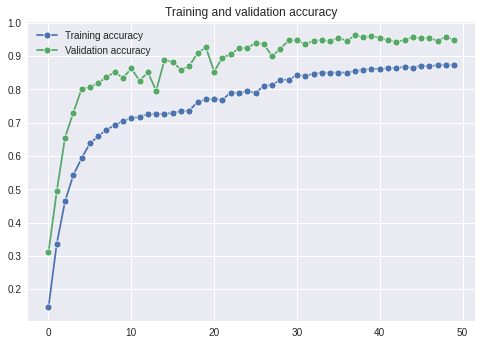

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



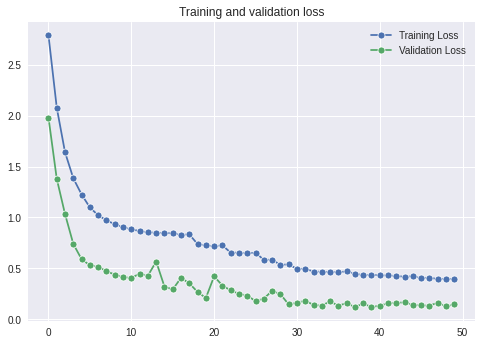

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
plt.style.use("seaborn")

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.title('Training and validation accuracy')
sns.lineplot(epochs, acc, label="Training accuracy", marker="o")
sns.lineplot(epochs, val_acc, label="Validation accuracy", marker="o")
plt.show()

plt.figure()
plt.title("Training and validation loss")
sns.lineplot(epochs, loss, label="Training Loss", marker="o")
sns.lineplot(epochs, val_loss, label="Validation Loss", marker="o")
plt.show()

We create our own model from scratch using CNN and get a pretty good result with above 87% accuracy in training and around 94% in testing